Starting from first experiments, now testing out an approach using "hybrid" classes that are part astropy.modeling and part independent.

In [246]:
%matplotlib inline
from matplotlib import pyplot as plt

In [ ]:
import sys

pathtoinsert = '..'  # should have emceemr
if pathtoinsert not in sys.path:
    sys.path.insert(1, pathtoinsert)

import emceemr

In [239]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
from dataclasses import dataclass
from typing import Any
from types import MappingProxyType
from collections import OrderedDict
from collections.abc import Mapping

import numpy as np
from scipy import stats

from astropy import modeling

MINF = -np.inf


__all__ = ['ProbabilisticModel', 'ProbabilisticParameter']


@dataclass
class ProbabilisticParameter:
    name: str
    description: str = ''
    prior: stats._distn_infrastructure.rv_generic = None
    posterior_samples: Any = None
        

class ParameterMapping(Mapping):
    def __init__(self, parent, param_names):
        self._parent = parent
        self._param_names = tuple(param_names)
        
    def __len__(self):
        return len(self._param_names)
    
    def __iter__(self):
        return iter(self._param_names)
            
    def __getitem__(self, nm):
        if nm not in self._param_names:
            raise KeyError(nm)
        return getattr(self._parent, nm)
    
    def __repr__(self):
        return str(dict(self))


class ProbabilisticModel:
    """
    A container for a mean model (astropy model) plus a noise model.

    Parameters
    ----------
    mean_model : astropy.modeling model
        An astropy model representing the mean model
    data_distribution : astropy.modeling model
        A model that takes ('mean_model_result', 'data') and yields the logpdf.
        See `noise_models.generate_logpdfmodel_class`.
    """

    def __init__(self, mean_model, data_distribution):
        self.mean_model = mean_model
        self.data_distribution = data_distribution
        self.cross_prior = None
        
        parameters = []
        self._mean_parameters = []
        self._data_parameters = []
        for param_name in mean_model.param_names:
            p = ProbabilisticParameter(param_name, description=f'mean model parameter "{param_name}"')
            self._mean_parameters.append(p.name)
            parameters.append(p)
            
        for param_name in data_distribution.param_names:
            p = ProbabilisticParameter(param_name, description=f'data distribution parameter "{param_name}"')
            self._data_parameters.append(p.name)
            parameters.append(p)
        
        param_names = []
        for p in parameters:
            setattr(self, p.name, p)
            param_names.append(p.name)
        self.parameters = ParameterMapping(self, param_names)
        
    def __repr__(self):
        cname = self.__class__.__name__
        params_str = ', '.join(self.parameters.keys())
        return f'<{cname}({params_str})>'
    
    def ln_priors(self, parameter_values, datax, datay):
        lpri = 0
        for p, val in zip(self.parameters.values(), parameter_values):
            if p.prior is not None:
                lpri += p.prior.logpdf(val)
                if lpri == MINF:
                    return lpri
        if self.cross_prior is not None:
            lpri += self.cross_prior(*parameter_values)
        return lpri
    
    def ln_likelihood(self, parameter_values, datax, datay):
        model_val = self.mean_model.evaluate(datax, *parameter_values[:len(self._mean_parameters)])
        return self.data_distribution.evaluate(model_val, datay, *parameter_values[-len(self._data_parameters):])
    
    def ln_prob(self, parameter_values, datax, datay):
        lpri = self.ln_priors(parameter_values, datax, datay)
        if lpri == MINF:
            return lpri
        else:
            llike = self.ln_likelihood(parameter_values, datax, datay)
            return lpri + np.sum(llike, axis=-1)

In [240]:
from emceemr.noise_models import generate_logpdfmodel_class
import collections

from astropy import modeling
from astropy.utils import find_current_module


mean_model = modeling.models.Linear1D(slope=2, intercept=1)
noise_model = generate_logpdfmodel_class(stats.norm(scale=1), scale_param_name='sigma')(sigma=1.5)

pm = ProbabilisticModel(mean_model, noise_model)
pm, pm.parameters

(<ProbabilisticModel(slope, intercept, sigma)>,
 {'slope': ProbabilisticParameter(name='slope', description='mean model parameter "slope"', prior=None, posterior_samples=None), 'intercept': ProbabilisticParameter(name='intercept', description='mean model parameter "intercept"', prior=None, posterior_samples=None), 'sigma': ProbabilisticParameter(name='sigma', description='data distribution parameter "sigma"', prior=None, posterior_samples=None)})

In [241]:
sample_x = np.linspace(0, 10, 100)
sample_y = pm.data_distribution.distribution.rvs(loc=pm.mean_model(sample_x), scale=pm.data_distribution.sigma)

pm.ln_prob([pm.mean_model.slope, pm.mean_model.intercept, pm.data_distribution.sigma], sample_x, sample_y)

-174.37748950844042

In [328]:
#grid map

sl, itr, sig = np.mgrid[1:3:301j, 0:2:301j, 0.5:3:11j]
lnps = pm.ln_prob([sl[...,np.newaxis], itr[...,np.newaxis], sig[...,np.newaxis]], sample_x, sample_y)

lnps.shape

(301, 301, 11)

In [329]:
best_sig_idx = np.where(sig[0, 0]==1.5)[0][0]
best_sl_idx = np.where(sl[:, 0, 0]==2)[0][0]
best_itr_idx = np.where(itr[0, :, 0]==1)[0][0]
best_sig_idx, best_sl_idx, best_itr_idx

(4, 150, 150)

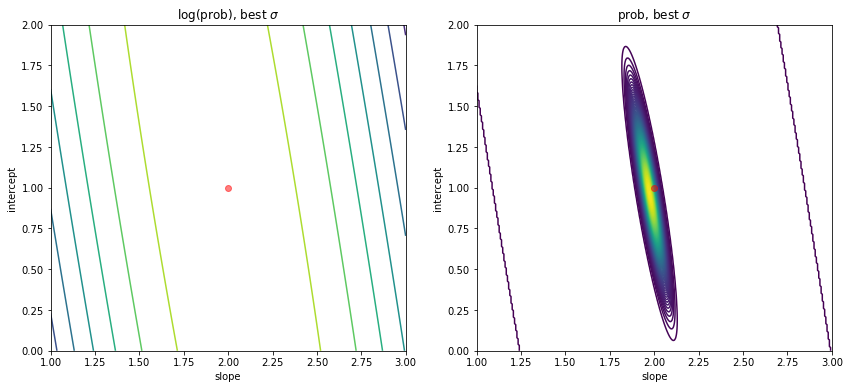

In [330]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.contour(sl[..., best_sig_idx], itr[..., best_sig_idx], lnps[..., best_sig_idx])
ax1.set_title(r'log(prob), best $\sigma$')
ax2.contour(sl[..., best_sig_idx], itr[..., best_sig_idx], np.exp(lnps[..., best_sig_idx]), levels=100)
ax2.set_title('prob, best $\sigma$')
for ax in (ax1, ax2):
    ax.set_xlabel('slope')
    ax.set_ylabel('intercept')
    ax.scatter([pm.mean_model.slope], [pm.mean_model.intercept], c='r', zorder=3, alpha=.5)

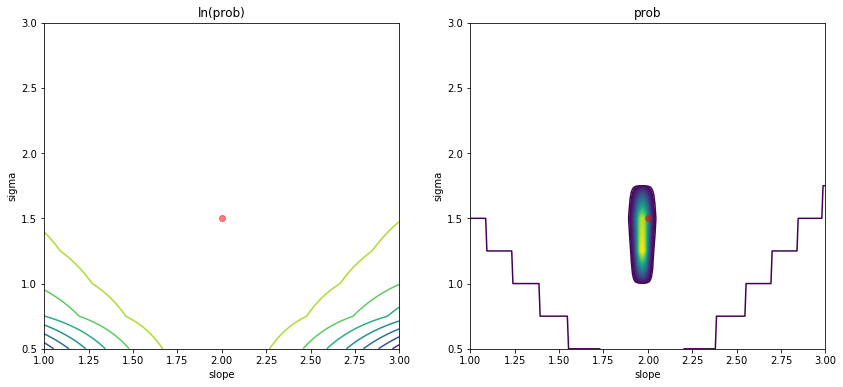

In [333]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.contour(sl[:, best_itr_idx, :], sig[:, best_itr_idx, :], lnps[:, best_itr_idx, :])
ax1.set_title(r'ln(prob)')
ax2.contour(sl[:, best_itr_idx, :], sig[:, best_itr_idx, :], np.exp(lnps[:, best_itr_idx, :]), levels=100)
ax2.set_title('prob')
for ax in (ax1, ax2):
    ax.set_xlabel('slope')
    ax.set_ylabel('sigma')
    ax.scatter([pm.mean_model.slope], [pm.data_distribution.sigma], c='r', zorder=3, alpha=.5)

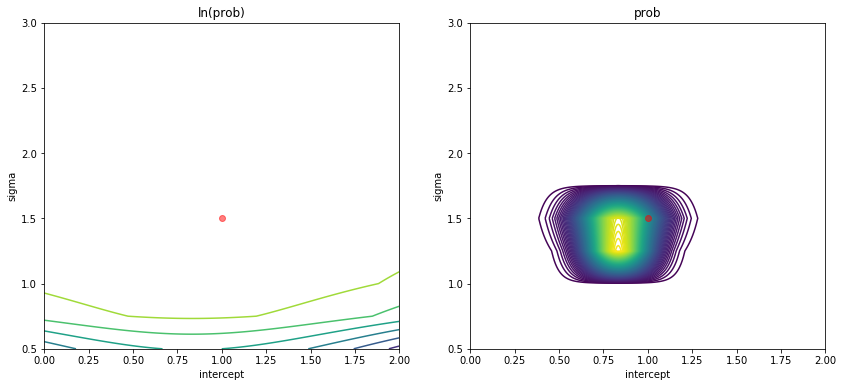

In [335]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.contour(itr[best_sl_idx, :, :], sig[best_sl_idx, :, :], lnps[best_sl_idx, :, :])
ax1.set_title(r'ln(prob)')
ax2.contour(itr[best_sl_idx, :, :], sig[best_sl_idx, :, :], np.exp(lnps[best_sl_idx, :, :]), levels=100)
ax2.set_title('prob')
for ax in (ax1, ax2):
    ax.set_xlabel('intercept')
    ax.set_ylabel('sigma')
    ax.scatter([pm.mean_model.intercept], [pm.data_distribution.sigma], c='r', zorder=3, alpha=.5)